## Reference
- [Recurrent Neural Networks in Tensorflow I](http://r2rt.com/recurrent-neural-networks-in-tensorflow-i.html)

## Outline of the data

In [1]:
import numpy as np

print("Expected cross entropy loss if the model:")
print("- learns neither dependency:", -(0.625 * np.log(0.625) +
                                      0.375 * np.log(0.375)))
# Learns first dependency only ==> 0.51916669970720941
print("- learns first dependency:  ",
      -0.5 * (0.875 * np.log(0.875) + 0.125 * np.log(0.125))
      -0.5 * (0.625 * np.log(0.625) + 0.375 * np.log(0.375)))
print("- learns both dependencies: ", -0.50 * (0.75 * np.log(0.75) + 0.25 * np.log(0.25))
      - 0.25 * (2 * 0.50 * np.log (0.50)) - 0.25 * (0))

Expected cross entropy loss if the model:
- learns neither dependency: 0.661563238158
- learns first dependency:   0.519166699707
- learns both dependencies:  0.454454367449


## Imports, config variables and data generators

In [2]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn; seaborn.set()

In [3]:
# Global config variables
num_steps = 5 # number of truncated backprop steps ('n' in the discussion abox)
batch_size = 200
num_classes = 2
state_size = 4
learning_rate = 0.1

In [4]:
def gen_data(size=1000000):
    X = np.array(np.random.choice(2, size=(size, )))
    y = []
    for i in range(size):
        threshold = 0.5
        if X[i-3] == 1:
            threshold += 0.5
        if X[i-8] == 1:
            threshold -= 0.25
        if np.random.rand() > threshold:
            y.append(0)
        else:
            y.append(1)
    return X, np.array(y)

# adapted from https://github.com/tensorflow/tensorflow/blob/master/tensorflow/models/rnn/ptb/reader.py
def gen_batch(raw_data, batch_size, num_steps):
    raw_x, raw_y = raw_data
    data_length = len(raw_x)
    
    #partition raw data into batches and stack theme vertically in a data matrix
    batch_partition_length = data_length // batch_size
    data_x = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    data_y = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    for i in range(batch_size):
        data_x[i] = raw_x[batch_partition_length * i:batch_partition_length * (i+1)]
        data_y[i] = raw_y[batch_partition_length * i:batch_partition_length * (i+1)]
    # further divide batch partitions into num_steps for truncated backprop
    epoch_size = batch_partition_length // num_steps
    
    for i in range(epoch_size):
        x = data_x[:, i * num_steps: (i+1) * num_steps]
        y = data_y[:, i * num_steps: (i+1) * num_steps]
        yield (x, y)
        
def gen_epochs(n, num_steps):
    for i in range(n):
        yield gen_batch(gen_data(), batch_size, num_steps)

## Model

In [5]:
# Placeholders

x = tf.placeholder(tf.int32, [batch_size, num_steps], name='input_placeholder')
y = tf.placeholder(tf.int32, [batch_size, num_steps], name='labels_placeholder')
init_state = tf.zeros([batch_size, state_size])

# RNN Inputs

# Turn our x placeholder into a list of one-hot tensors:
# rnn_inputs is a list of num_steps tensors with shape [batch_size, num_classes]
x_one_hot = tf.one_hot(x, num_classes)
rnn_inputs = tf.unstack(x_one_hot, axis=1)

# Definition of rnn_cell

# This is very similar to the __call__ method on Tensorflow's BasicRNNCell. See:
# https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/ops/rnn_cell.py

with tf.variable_scope('rnn_cell'):
    W = tf.get_variable('W', [num_classes + state_size, state_size])
    b = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))
    
def rnn_cell(rnn_input, state):
    with tf.variable_scope('rnn_cell', reuse=True):
        W = tf.get_variable('W', [num_classes + state_size, state_size])
        b = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))
    return tf.tanh(tf.matmul(tf.concat([rnn_input, state], 1), W) + b)

In [6]:
# Adding rnn_cells to graph

# This is a simplified version of the "rnn" function from Tensorflow's api. See:
# https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/ops/rnn.py

state = init_state
rnn_outputs = []
for rnn_input in rnn_inputs:
    state = rnn_cell(rnn_input, state)
    rnn_outputs.append(state)
final_state = rnn_outputs[-1]

# Predictions, loss, trainig step

# Losses and totol_loss are similar to the "sequence_loss_by_example" and "sequence_loss"
# functions, respectively, from Tensorflow's api. See:
# https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/ops/seq2seq.py

# logits and predicitons
with tf.variable_scope('softmax'):
    W = tf.get_variable('W', [state_size, num_classes])
    b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0))
logits = [tf.matmul(rnn_output, W) + b for rnn_output in rnn_outputs]
predictions = [tf.nn.softmax(logit) for logit in logits]

# Turn our y placeholder into a list labels
y_as_list = [tf.squeeze(i, axis=[1]) for i in tf.split(y, num_steps, axis=1)]

# losses and trin step
losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logit, labels=label) for 
          logit, label in zip(logits, y_as_list)]
total_loss = tf.reduce_mean(losses)
train_step = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)

## Train

In [7]:
def train(num_epochs, num_steps, state_size=4, verbose=True):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        training_losses = []
        for idx, epoch in enumerate(gen_epochs(num_epochs, num_steps)):
            training_loss = 0
            training_state = np.zeros((batch_size, state_size))
            if verbose:
                print("\nEPOCH", idx)
            for step, (X, Y) in enumerate(epoch):
                tr_losses, training_loss_, training_state, _ = sess.run(
                    [losses, total_loss, final_state, train_step],
                    feed_dict={x:X, y:Y, init_state:training_state}
                )
                training_loss += training_loss_
                if step % 100 == 0 and step > 0:
                    if verbose:
                        print("Average loss at step", step,
                              "for last 250 steps:", training_loss/100)
                    training_losses.append(training_loss/100)
                    training_loss = 0

    return training_losses


EPOCH 0
Average loss at step 100 for last 250 steps: 0.664683010578
Average loss at step 200 for last 250 steps: 0.602604764104
Average loss at step 300 for last 250 steps: 0.549217424095
Average loss at step 400 for last 250 steps: 0.514428795576
Average loss at step 500 for last 250 steps: 0.51855881542
Average loss at step 600 for last 250 steps: 0.519101875722
Average loss at step 700 for last 250 steps: 0.517414500713
Average loss at step 800 for last 250 steps: 0.515126209855
Average loss at step 900 for last 250 steps: 0.5168133986


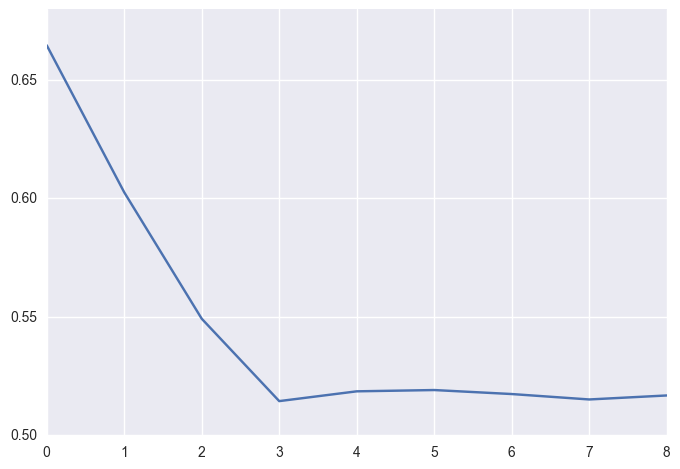

In [8]:
training_losses = train(1, num_steps)
plt.plot(training_losses)

the network very quickly learns to capture the first dependency (0.52)

In [9]:
import basic_rnn
def plot_learning_curve(num_steps, state_size=4, epochs=1):
    global losses, total_loss, final_state, train_step, x, y, init_state
    tf.reset_default_graph()
    g = tf.get_default_graph()
    losses, total_loss, final_state, train_step, x, y, init_state = basic_rnn.setup_graph(
        g, basic_rnn.RNN_config(num_steps=num_steps, state_size=state_size))
    res = train(epochs, num_steps, state_size=state_size, verbose=False)
    plt.plot(res)

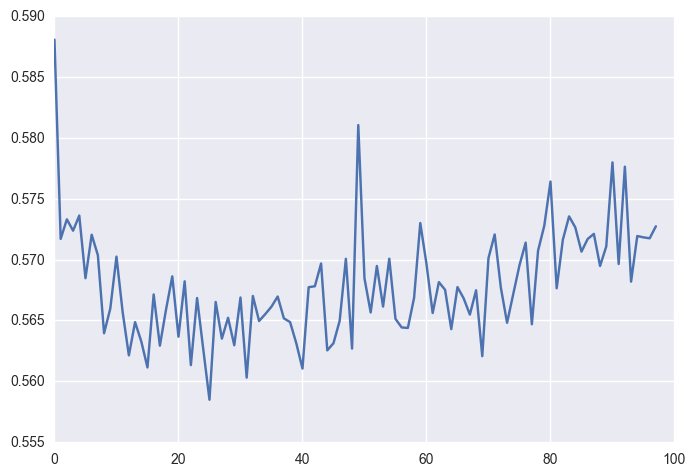

In [10]:
plot_learning_curve(num_steps=1, state_size=4, epochs=2)

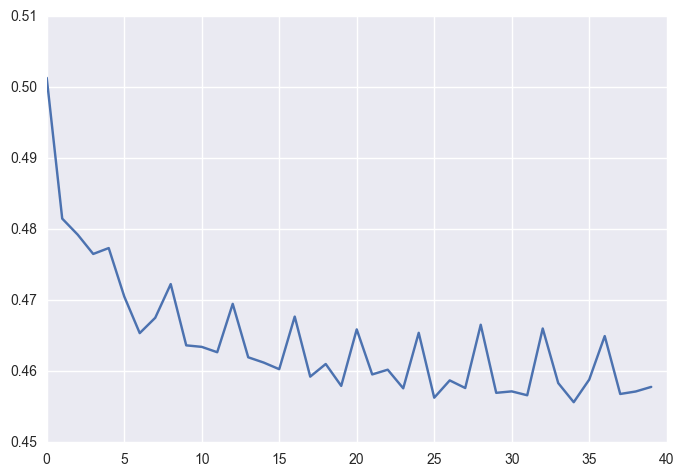

In [11]:
plot_learning_curve(num_steps=10, state_size=16, epochs=10)

num_steps = 10 comes close to our expected cross_entropy for knowing both dependecies(0.454)

## Translating our model to Tensorflow

In [ ]:
import tensorflow as tf

# Global config variables
num_steps = 5 # number of truncated backprop steps ('n' in the discussion abox)
batch_size = 200
num_classes = 2
state_size = 4
learning_rate = 0.1

# Placeholders

x = tf.placeholder(tf.int32, [batch_size, num_steps], name='input_placeholder')
y = tf.placeholder(tf.int32, [batch_size, num_steps], name='labels_placeholder')
init_state = tf.zeros([batch_size, state_size])

# Inputs

x_one_hot = tf.one_hot(x, num_classes)
rnn_inputs = tf.unstack(x_one_hot, axis=1)

# RNN

cell = tf.contrib.rnn.BasicRNNCell(state_size)
rnn_outputs, final_state = tf.contrib.rnn.static_rnn(cell, rnn_inputs, initial_state=init_state)

# Predictions, loss, training step

with tf.variable_scope('softmax'):
    W = tf.get_variable('W', [state_size, num_classes])
    b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0))
logits = tf.stack([tf.matmul(rnn_output, W) + b for rnn_output in rnn_outputs], axis=2)
predictions = tf.nn.softmax(logits)
targets = y

loss_weights = tf.ones([batch_size, num_steps])
losses = tf.contrib.seq2seq.sequence_loss(logits, targets, loss_weights)
total_loss = tf.reduce_mean(losses)
train_step = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)